In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid


from torchvision import datasets
from torchvision import transforms


In [8]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist\MNIST\raw


Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist\MNIST\raw


Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist\MNIST\raw


Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist\MNIST\raw
Processing...


C:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


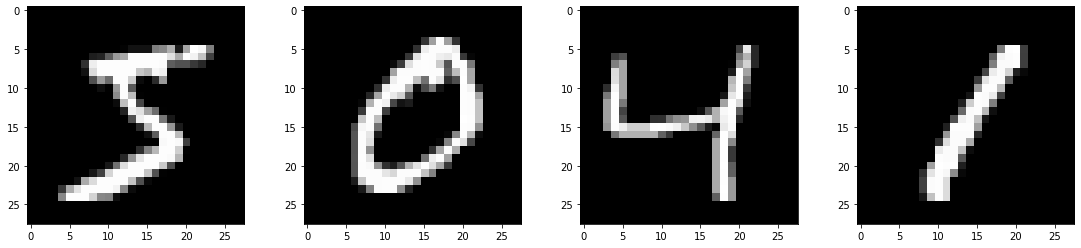

In [9]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')

plt.show()

In [12]:
class Perceptron(torch.nn.Module):
    # количество начальных признаков 784 (количество пикселей), пространство скрытых параметров 64 признака, выходные признаки 10.
    # p - вероятность выбрасывания элемента из выборки (dropout), device - что вычисляет процессор или видеокарта.
    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim  # размерность матрицы входного скрытого слоя должна совпадать с разм. предыдущего слоя
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))#проводим dropout выкидываем значения с вероятн. p
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        self.to(device)
        
    def forward(self, input):
        return self.layers(input)
    

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model = Perceptron(device=device)
model


Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [19]:
model = Perceptron(num_layers=1, device=device)
model


Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
model = Perceptron(num_layers=2, device=device)
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [22]:
def testing(model, dataset):
    # память может быстро переполнится, поэтому нужно подавать данные нейросети по кусочкам (64)
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = [] # предсказанные ответы
    real = [] # истинные ответы
    for x, y in tqdm(generator, leave=False):
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [24]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                              shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [25]:
def draw_table(data, title=['ACCURACY'], width=[60, 15]):    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))


In [26]:
model = Perceptron(num_layers=0, device=device)


In [27]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)


              precision    recall  f1-score   support

           0       0.08      0.19      0.11       980
           1       0.07      0.08      0.07      1135
           2       0.02      0.01      0.01      1032
           3       0.06      0.02      0.03      1010
           4       0.10      0.18      0.13       982
           5       0.13      0.08      0.10       892
           6       0.19      0.37      0.25       958
           7       0.12      0.01      0.02      1028
           8       0.05      0.05      0.05       974
           9       0.05      0.01      0.02      1009

    accuracy                           0.10     10000
   macro avg       0.09      0.10      0.08     10000
weighted avg       0.09      0.10      0.08     10000



In [29]:
_ = model.train()
trainer(model=model, 
        dataset=MNIST_train, # датасет
        loss_function=torch.nn.CrossEntropyLoss(), # задание функции ошибки
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), # функция оптимизации и learning rate
        epochs=4)


In [30]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.95      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.90      0.89       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [31]:
# Подбираем параметры с помощью кросс-валидации (скользящий контроль)
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'num_layers': [0, 2], 
                      'hidden_dim': [8, 64],
                      'p': [0.3, 0.7],
                      'lr': [0.001]})

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0,1)
Y_train = MNIST_train.targets.data

In [32]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)


        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'], device=device)
        _ = model.train()
        trainer(model=model, 
                dataset=traindata, 
                loss_function=torch.nn.CrossEntropyLoss(), 
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']), 
                epochs=4)
        
        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
draw_table(scores)


+------------------------------------------------------------+---------------+
|                                                            |       ACCURACY|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|           0.91|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}|           0.92|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}|           0.78|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}|           0.48|
+------------------------------------------------------------+---------------+
|  {'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|           0.92|
+---------------------------------------------------